In [1]:
import os
import sys
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

module_dir = os.path.abspath('../src')  # Adjust path as needed
sys.path.append(module_dir)

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import numpy.testing as npt
from operator import itemgetter, attrgetter
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14
pd.options.display.float_format = '{:.2g}'.format

2024-11-10 09:14:42


In [2]:
from pynext.system_of_units import *

In [3]:
from pynext.Material import PhysicalMaterial
from pynext.PhysicalVolume import PhysicalVolume
from pynext.Shapes import Cylinder, CylinderShell, FlatPlate

In [4]:
from pynext.xetd import Xenon, CXe

In [5]:
from pynext.geometry import draw_cylinder, draw_2cylinder, draw_2cylynder_surface
from pynext.geometry import Cylinder as GCylinder
from pynext.geometry import vectors_spherical
from pynext.geometry import Ray, ray_intersection_with_cylinder
from pynext.geometry import generate_and_transport_gammas_lxe_shell
from pynext.geometry import generate_and_transport_gammas_lxe_endcaps
from pynext.histograms import h1d

In [6]:
from pynext.CylindricalVessel import  CVD
from pynext.CylindricalVessel import  CylindricalVessel
from pynext.Material import  cu12
from pynext.activity_functions import  activity_of_CV, print_activity_of_CV

## toy Xenon detector
- Cylinder filled with Xe gas at a pressure P
- Vessel made of radiopure copper

- GXe: SiPMs at a pitch of 10 mm. Fibers of 1 mm.
- LXe: quartz-based readout. SiPMs in the barrel.
- Although gxetd and lxetd are "toy detectors" we will incorporate a modicum or realism associated with their respective designs.
    - gxetd is a symmetric HPXe TPC operating at 15 bar. We assume a buffer of 1 cm in the radial direction, 1 cm in the anode and 1 cm in the cathode (the size of the EL region, where events are not recorded).
    - lxetd is an asymmetric LXe TPC. We assume 1 mm of buffer in the anode (e.g, events too close to the readout) and 10 cm in the cathode, to degrade the field.

### Define materials

#### Xenon

In [116]:
gxe15 = Xenon('xe_1520')
print(gxe15)


        material                                   = xe_1520
        density (rho)                              =    0.09 g/cm3
        mass attenuation coefficient (mu_over_rho) =   0.039 cm2/g
        attenuation coefficient (mu)               =  0.0035 cm^-1
        attenuation length (Latt)                  = 2.9e+02 cm
    


In [117]:
lxe = Xenon("lxe")
lxe


        material                                   = lxe
        density (rho)                              =       3 g/cm3
        mass attenuation coefficient (mu_over_rho) =   0.039 cm2/g
        attenuation coefficient (mu)               =    0.12 cm^-1
        attenuation length (Latt)                  =     8.5 cm
    

#### Xenon Volume


In [122]:
Rg = 1.1*m
Lg = 3.0*m
gxetd = CXe(gxe15, R=Rg, L=Lg, Rb=1*cm, Cb=1*cm, Ab=1*cm)

In [123]:
gxetd


        
        material                                   = xe_1520
        density (rho)                              =    0.09 g/cm3
        mass attenuation coefficient (mu_over_rho) =   0.039 cm2/g
        attenuation coefficient (mu)               =  0.0035 cm^-1
        attenuation length (Latt)                  = 2.9e+02 cm
    
        
        Fiducial Radius =  110.00 cm  xe Radius =  111.00 cm
        Fiducial Length =  300.00 cm  Xe Length =  302.00 cm
        
        Fiducial Volume =   11.40 m3 Xe Volume =   11.69 m3
        Fiducial mass = 1025.22 kg Xe mass = 1050.90 kg
        
        Radial buffer radius =    1.00 cm (E/P ~ 2)
        Cathode buffer thickness =    1.00 cm   (E/P~1)
        Anode buffer thickness =    1.00 cm
        
        Long buffer Volume =    0.21 m3
        Long buffer mass =   18.85 kg
        
        Cathode buffer Volume =    0.04 m3
        Cathode buffer mass =    3.48 kg
        
        Anode buffer Volume =    0.04 m3
        Anod

In [143]:
cod = 1153 * mm
frid = 1133 * mm
Rl = frid/2
Rb = (cod - frid) / 2
ltpc = 1277 * mm
ldft = 1183 * mm
Ll = ldft
Cb = ltpc - ldft
ab_to_tpc_top = 19*mm
Ab = ab_to_tpc_top
lxetd = CXe(lxe, R=Rl, L=Ll, Rb=Rb, Cb=Cb, Ab=Ab)
lxetd


        
        material                                   = lxe
        density (rho)                              =       3 g/cm3
        mass attenuation coefficient (mu_over_rho) =   0.039 cm2/g
        attenuation coefficient (mu)               =    0.12 cm^-1
        attenuation length (Latt)                  =     8.5 cm
    
        
        Fiducial Radius =   56.65 cm  xe Radius =   57.65 cm
        Fiducial Length =  118.30 cm  Xe Length =  127.80 cm
        
        Fiducial Volume =    1.19 m3 Xe Volume =    1.33 m3
        Fiducial mass = 3578.13 kg Xe mass = 4003.14 kg
        
        Radial buffer radius =    1.00 cm (E/P ~ 2)
        Cathode buffer thickness =    9.40 cm   (E/P~1)
        Anode buffer thickness =    0.10 cm
        
        Long buffer Volume =    0.05 m3
        Long buffer mass =  137.67 kg
        
        Cathode buffer Volume =    0.10 m3
        Cathode buffer mass =  294.44 kg
        
        Anode buffer Volume =    0.00 m3
        Anode bu

In [182]:
## Define a second LXe volume, the shielded volume in which one carries on physics (1 ton fiducial)
Rs = 0.41*m
Ls = 0.65*m
lxes = CXe(lxe, R=Rs, L=Ls, Rb=1*mm, Cb=1*mm, Ab=1*mm)

lxe_phys_inner_radius = Rs
lxe_phys_inner_diameter = 2 * Rs
lxe_phys_length = Ls

In [145]:

lxes


        
        material                                   = lxe
        density (rho)                              =       3 g/cm3
        mass attenuation coefficient (mu_over_rho) =   0.039 cm2/g
        attenuation coefficient (mu)               =    0.12 cm^-1
        attenuation length (Latt)                  =     8.5 cm
    
        
        Fiducial Radius =   41.00 cm  xe Radius =   41.10 cm
        Fiducial Length =   65.00 cm  Xe Length =   65.20 cm
        
        Fiducial Volume =    0.34 m3 Xe Volume =    0.35 m3
        Fiducial mass = 1029.80 kg Xe mass = 1038.01 kg
        
        Radial buffer radius =    0.10 cm (E/P ~ 2)
        Cathode buffer thickness =    0.10 cm   (E/P~1)
        Anode buffer thickness =    0.10 cm
        
        Long buffer Volume =    0.00 m3
        Long buffer mass =    5.05 kg
        
        Cathode buffer Volume =    0.00 m3
        Cathode buffer mass =    1.59 kg
        
        Anode buffer Volume =    0.00 m3
        Anode bu

In [121]:
## Fraction of gammas that interact in GXe along L

In [126]:
gxetd.xe.material.absorption_at_qbb(Lg) 

0.6507020513737221

In [ ]:
## Fraction of gammas that interact in GXe along R

In [127]:
gxetd.xe.material.absorption_at_qbb(Rg) 

0.32000579302317445

In [146]:
## half attenuation length in LXe
la = (Ll - Ls)/2
## attenuation diameter in LXe
da = (Rl - Rs)
print(f"Length of attenuation buffer along Z: LXe = {la/cm} cm ")
print(f"Length of attenuation buffer along R: LXe = {da/cm} cm")

Length of attenuation buffer along Z: LXe = 26.65 cm 
Length of attenuation buffer along R: LXe = 15.65 cm


In [147]:
## Fraction of gammas that interact in Shielded volume

In [148]:
lxetd.xe.material.transmittance_at_qbb(la) 

0.04424335890652433

In [149]:
lxetd.xe.material.transmittance_at_qbb(da) 

0.16024522192604643

In [162]:
## LXe Copper TPC

pvl = 1727 * mm
pvd = 1277 * mm
cpth = 225 * mm

dth = (pvd - cod)/2


In [161]:
lxe_vessel_inner_radius = cod/2
lxe_vessel_body_thickness = dth
lxe_vessel_length = pvl
lxe_vessel_head_thickness = cpth
print(f"LXe copper Vessel: Length = {lxe_vessel_length/cm} cm, diameter = {lxe_vessel_inner_radius/cm} cm")
print(f"LXe copper Vessel: thickness body = {lxe_vessel_body_thickness/cm} cm, thickness head = {lxe_vessel_head_thickness/cm} cm")

LXe copper Vessel: Length = 172.7 cm, diameter = 57.65 cm
LXe copper Vessel: thickness body = 6.2 cm, thickness head = 22.5 cm


In [163]:
culxe = CVD(name    ='LXeCuVessel',
            R       = lxe_vessel_inner_radius,
            th_body = lxe_vessel_body_thickness,
            L       = lxe_vessel_length,
            th_head = lxe_vessel_head_thickness)

In [171]:
pvlxe = CylindricalVessel(name='LXeVessel', material=cu12, cvd=culxe)

In [172]:
pvlxe


        Cylindrical Vessel:

        ----------------
        name      = LXeCuVessel
        material  = CuUpperLimits

        specific activity of material:
        Bi-214    = 1.20e-02 mBq/kg
        Tl-208    = 1.40e-03 mBq/kg

        body:
        R              =  576.50 mm
        body thickness =   62.00 mm
        head thickness =  225.00 mm
        length         = 1727.00 mm
        surface        = 6.26e+06 mm2
        volume         = 4.09e+08 mm3
        mass           = 3662.00 kg
        activity Bi-214 =   43.94 mBq, self-shielded =   6.00 mBq
        activity Tl-208 =    5.13 mBq, self-shielded =   0.70 mBq
        transmittance   = 1.15e-01

        heads:
        thickness =  225.00 mm
        surface   = 2.09e+06 mm2
        volume    = 4.70e+08 mm3
        mass      = 4209.87 kg
        activity Bi-214 =   25.26 mBq, self-shielded =   1.02 mBq
        activity Tl-208 =    2.95 mBq, self-shielded =   0.12 mBq
        transmittance   = 3.85e-04

        

In [174]:
cs_activity = activity_of_CV('activity of LXe PV (self-shielded)', pvlxe)
print_activity_of_CV(cs_activity, unit='mBq')


    activity 		 activity of LXe PV (self-shielded)
    body  (Bi-214) 	    6.00 mBq
    head  (Bi-214) 	    1.02 mBq
    total (Bi-214) 	    7.02 mBq
    body  (Tl-208) 	    0.70 mBq
    head  (Tl-208) 	    0.12 mBq
    total (Tl-208) 	    0.82 mBq
    


In [592]:
## Geometry

In [506]:
cshell =GCylinder(lxe_vessel_inner_radius, 0, lxe_vessel_length)
cshell

Cylinder(r=576.5, zmin=0, zmax=1727.0)

In [507]:
print(f"LXe physics volume: Length = {lxe_phys_length/cm} cm, diameter = {lxe_phys_inner_diameter/cm} cm")

LXe physics volume: Length = 65.0 cm, diameter = 82.0 cm


In [508]:
zmin = (lxe_vessel_length - lxe_phys_length) / 2
zmax = zmin + lxe_phys_length
cphys =GCylinder(lxe_phys_inner_radius, zmin, zmax)
cphys

Cylinder(r=410.0, zmin=538.5, zmax=1188.5)

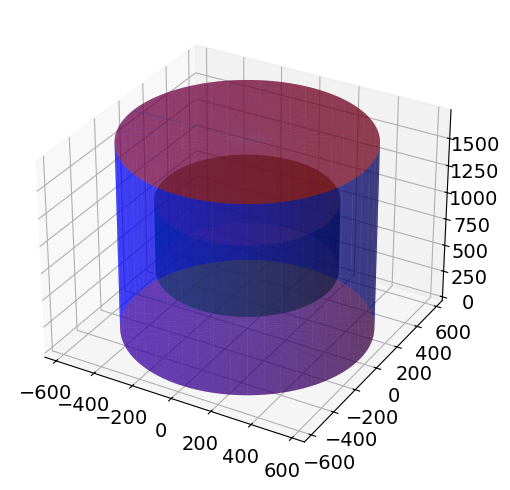

In [509]:
draw_2cylinder(cshell, cphys, alpha=0.5, figsize=(6,6))

In [510]:
## Test

In [511]:
r1 = 10  # Radius of cylinder c1
r2 = 6   # Radius of inner cylinder c2
zmin1 = -10  # Minimum z of cylinder c1
zmax1 = 10   # Maximum z of cylinder c1
zmin2 = -6   # Minimum z of cylinder c2
zmax2 = 6    # Maximum z of cylinder c2


c1 =GCylinder(r1, zmin1, zmax1)
c2 =GCylinder(r2, zmin2, zmax2)

In [600]:
np.zeros(3)

array([0., 0., 0.])

c1 =Cylinder(r=10, zmin=-10, zmax=10)
c2 =Cylinder(r=6, zmin=-6, zmax=6)


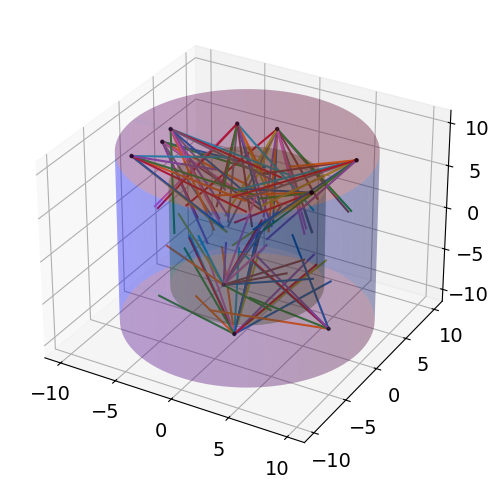

In [602]:
WF, DST = generate_and_transport_gammas_lxe_endcaps(c1, c2, 
                                       nphotons=10, ndx= 100, 
                                       solidAngle="half",
                                       verbose=1, drawRays=True, scale=10)

In [603]:
np.mean(WF)

0.19894263723050123

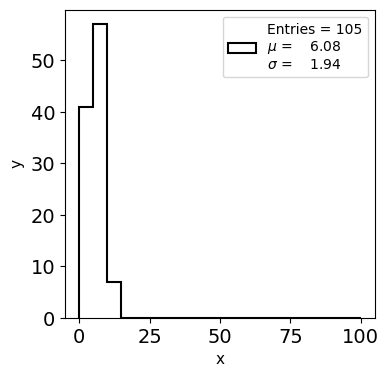

In [604]:
n, b, mu, std = h1d(DST, 20, (0, 100), figsize=(4,4)) 

c1 =Cylinder(r=10, zmin=-10, zmax=10)
c2 =Cylinder(r=6, zmin=-6, zmax=6)


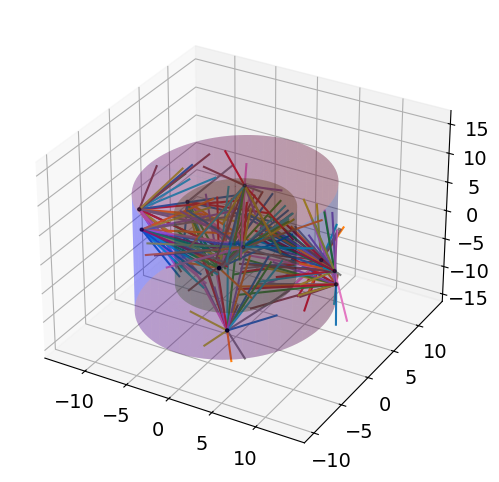

In [536]:
WF, DST = generate_and_transport_gammas_lxe_shell(c1, c2, 
                                       nphotons=10, ndx= 100, 
                                       solidAngle="half",
                                       verbose=1, drawRays=True)

In [537]:
np.mean(WF)

0.40337719231838987

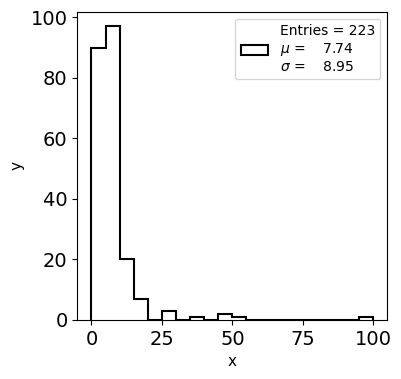

In [533]:
n, b, mu, std = h1d(DST, 20, (0, 100), figsize=(4,4)) 

c1 =Cylinder(r=10, zmin=-10, zmax=10)
c2 =Cylinder(r=6, zmin=-6, zmax=6)


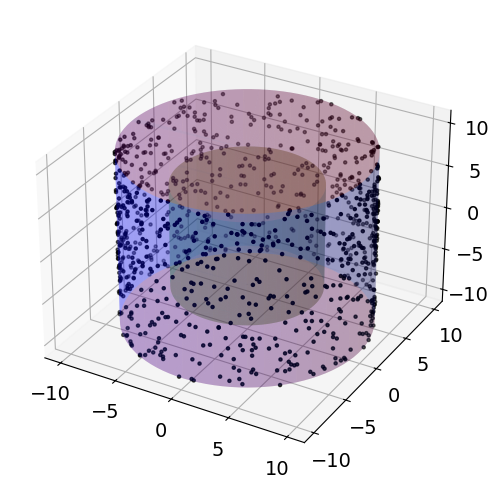

In [538]:
WF, DST = generate_and_transport_gammas_lxe_shell(c1, c2, 
                                       nphotons=1000, ndx= 100, 
                                       solidAngle="half",
                                       verbose=1, drawRays=False)

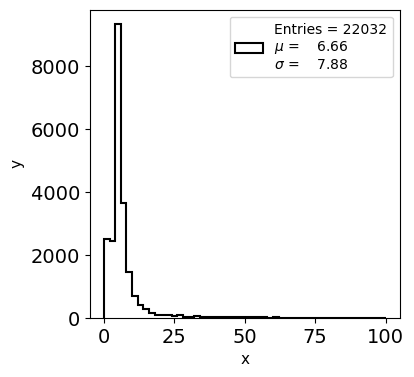

In [540]:
n, b, mu, std = h1d(DST, 50, (0, 100), figsize=(4,4)) 

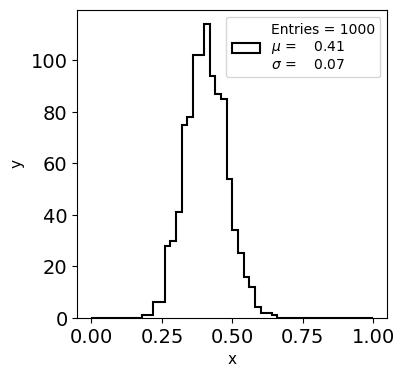

In [541]:
n, b, mu, std = h1d(WF, 50, (0, 1), figsize=(4,4)) 

c1 =Cylinder(r=576.5, zmin=0, zmax=1727.0)
c2 =Cylinder(r=410.0, zmin=538.5, zmax=1188.5)


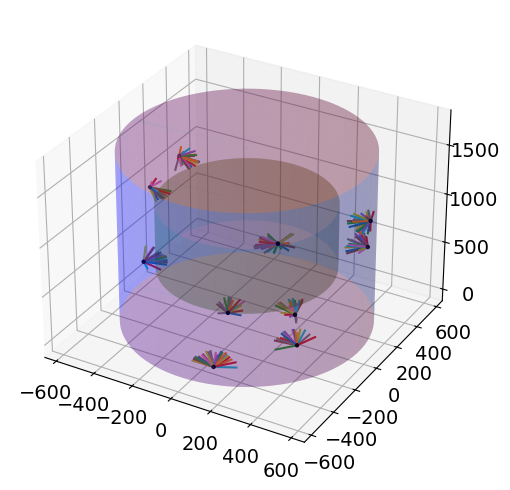

In [543]:
WF, DST = generate_and_transport_gammas_lxe_shell(cshell, cphys, 
                                       nphotons=10, ndx= 100, 
                                       solidAngle="half",
                                       verbose=1, drawRays=True, scale=100)

c1 =Cylinder(r=576.5, zmin=0, zmax=1727.0)
c2 =Cylinder(r=410.0, zmin=538.5, zmax=1188.5)


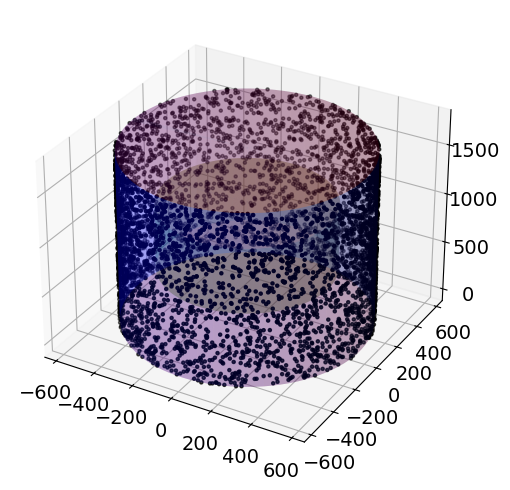

In [587]:
WF, DST = generate_and_transport_gammas_lxe_shell(cshell, cphys, 
                                       nphotons=5000, ndx= 100, 
                                       solidAngle="half",
                                       verbose=1, drawRays=False, scale=100)

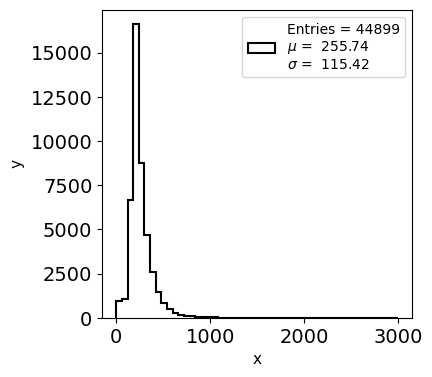

In [588]:
n, b, mu, std = h1d(DST, 50, (0, 3000), figsize=(4,4)) 

In [589]:
np.exp(-256/85)

0.049204770151623285

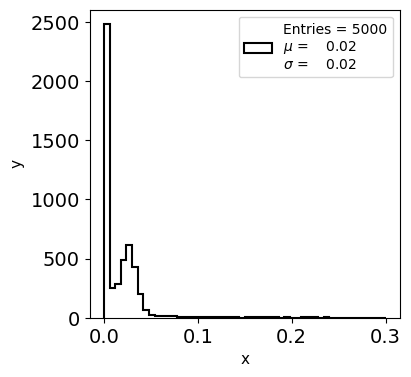

In [590]:
n, b, mu, std = h1d(WF, 50, (0, 0.3), figsize=(4,4)) 

In [591]:
print(f"mean weight in barrel = {std:7.2f}")

mean weight in barrel =    0.02


c1 =Cylinder(r=576.5, zmin=0, zmax=1727.0)
c2 =Cylinder(r=410.0, zmin=538.5, zmax=1188.5)


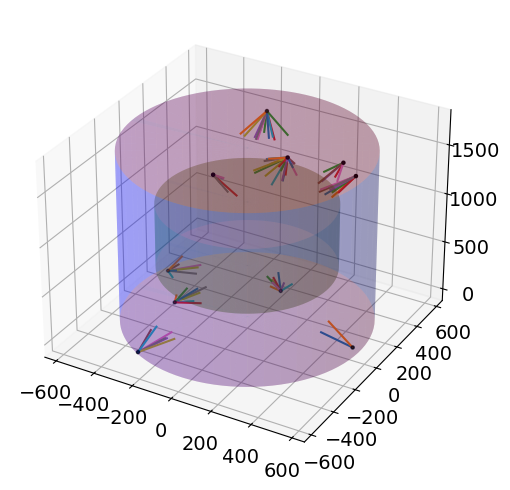

In [606]:
WF, DST = generate_and_transport_gammas_lxe_endcaps(cshell, cphys, 
                                       nphotons=10, ndx= 100, 
                                       solidAngle="half",
                                       verbose=1, drawRays=True, scale=200)

c1 =Cylinder(r=576.5, zmin=0, zmax=1727.0)
c2 =Cylinder(r=410.0, zmin=538.5, zmax=1188.5)


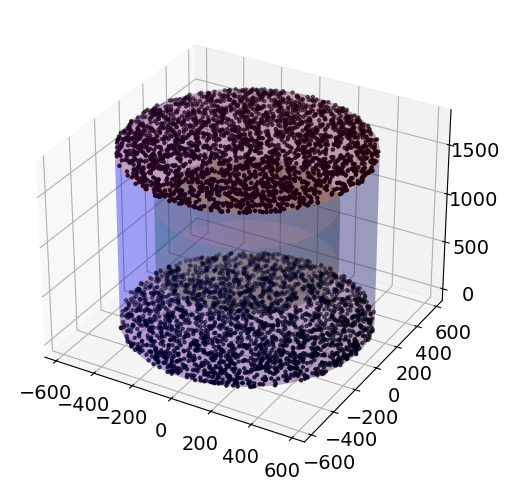

In [608]:
WF, DST = generate_and_transport_gammas_lxe_endcaps(cshell, cphys, 
                                       nphotons=5000, ndx= 100, 
                                       solidAngle="half",
                                       verbose=1, drawRays=False, scale=100)

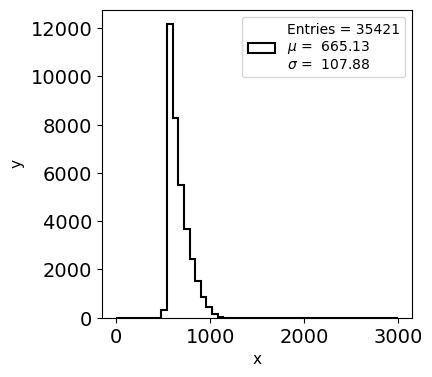

In [609]:
n, b, mu, std = h1d(DST, 50, (0, 3000), figsize=(4,4)) 

In [610]:
np.exp(-665/85)

0.0004002066930207512

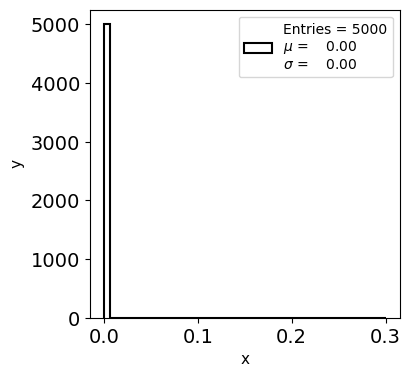

In [611]:
n, b, mu, std = h1d(WF, 50, (0, 0.3), figsize=(4,4)) 

In [612]:
np.mean(WF)

9.528513527260019e-05